# DiffEqFormer-SSM: Replacing FFN with Time-Varying State Space Models

This notebook implements and tests a hybrid architecture where we replace the feed-forward network (FFN) `g(x,t)` in the Neural ODE transformer with a time-varying Structured State Space Model (SSM/Mamba-2).

## Architecture Overview

The ODE formulation becomes:
$$\dot{x}(t) = f_{\text{attn}}(x, t) + g_{\text{ssm}}(x, t)$$

where:
- $f_{\text{attn}}(x, t)$: Time-varying attention (unchanged)
- $g_{\text{ssm}}(x, t)$: Time-varying SSM block (new!)

The SSM parameters $(A(t), B(t), C(t), \Delta(t))$ are generated by the same time-dependent hypernetwork using Fourier time embeddings.


In [10]:
# Setup and imports
import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import haliax as hax
import haliax.nn as hnn
from haliax import NamedArray, Axis
from haliax.jax_utils import maybe_rng_split, named_call
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Callable

# Import existing components
from qkvflow.nn.time_embed import SinusoidalPosEmb
from qkvflow.nn.dynamic import TemporalLinear, Attention, MLP, Block
from levanter.models.gpt2 import Gpt2Config

print(f"JAX devices: {jax.devices()}")
print(f"JAX version: {jax.__version__}")

JAX devices: [CpuDevice(id=0)]
JAX version: 0.6.2


## 1. Implement Time-Varying SSM Block

We implement a simplified S4/Mamba-style SSM with time-dependent parameters.


In [30]:
class TemporalSSM(eqx.Module):
    """Time-varying Structured State Space Model
    
    Implements a simplified SSM with parameters A(t), B(t), C(t), Δ(t)
    generated from the time-dependent hypernetwork.
    """
    
    # Hypernetwork components
    lin1: hnn.Linear
    lin2: hnn.Linear
    
    # Parameter generators
    f_A: hnn.Linear
    f_B: hnn.Linear  
    f_C: hnn.Linear
    f_D: hnn.Linear
    f_delta: hnn.Linear
    
    # Axes
    Embed: hax.AxisSpec = eqx.field(static=True)
    StateSize: hax.Axis = eqx.field(static=True)
    TembedDim: hax.AxisSpec = eqx.field(static=True)
    
    @staticmethod
    def init(SinusodialDim, TembedDim, Embed, state_size=64, *, key):
        k_lin1, k_lin2, k_A, k_B, k_C, k_D, k_delta = jrandom.split(key, 7)
        
        StateSize = hax.Axis("StateSize", state_size)
        TembedDim_alias = TembedDim.alias("TembedDim_alias")
        
        lin1 = hnn.Linear.init(SinusodialDim, TembedDim_alias, key=k_lin1)
        lin2 = hnn.Linear.init(TembedDim_alias, TembedDim, key=k_lin2)
        
        # SSM parameter generators  
        f_A = hnn.Linear.init(TembedDim, StateSize, key=k_A, use_bias=True)
        f_B = hnn.Linear.init(TembedDim, (StateSize, Embed), key=k_B, use_bias=True)
        f_C = hnn.Linear.init(TembedDim, (Embed, StateSize), key=k_C, use_bias=True)
        f_D = hnn.Linear.init(TembedDim, Embed, key=k_D, use_bias=True)
        f_delta = hnn.Linear.init(TembedDim, StateSize, key=k_delta, use_bias=True)
        
        return TemporalSSM(
            lin1, lin2, f_A, f_B, f_C, f_D, f_delta,
            Embed, StateSize, TembedDim
        )
    
    def _get_params(self, time_embed):
        t_emb = self.lin1(time_embed)
        t_emb = hnn.silu(t_emb)
        t_emb = self.lin2(t_emb)
        
        A_diag = -hnn.softplus(self.f_A(t_emb))
        B = self.f_B(t_emb)
        C = self.f_C(t_emb)
        D = self.f_D(t_emb)
        delta = hnn.softplus(self.f_delta(t_emb)) + 1e-4
        
        return A_diag, B, C, D, delta
    
    @named_call
    def __call__(self, time_embed, x, *, key=None):
        A_diag, B, C, D, delta = self._get_params(time_embed)
        
        # Discretize
        A_bar = hax.exp(delta * A_diag)
        # In Haliax, broadcasting happens automatically based on named axes
        # delta has axis StateSize, B has axes (StateSize, Embed)
        # Multiplication will broadcast correctly
        B_bar = delta * B
        
        # Selective scan
        def scan_fn(h, x_t):
            h_new = A_bar * h + hax.dot("embed", B_bar, x_t)
            y = hax.dot("StateSize", C, h_new)
            return h_new, y
        
        # Initialize h_0 with batch dimensions from x
        batch_axes = tuple(ax for ax in x.axes if ax not in [self.Embed] and ax.name != "position")
        h_0 = hax.zeros(batch_axes + (self.StateSize,))
        _, outputs = hax.scan(scan_fn, axis="position")(h_0, x)
        
        outputs = outputs + D * x
        return hax.auto_sharded(outputs)

print("✓ TemporalSSM implemented")


✓ TemporalSSM implemented


## 2. Create Hybrid Block (Attention + SSM)


In [31]:
from qkvflow.nn.dynamic import TemporalLayerNorm

class SSMBlock(eqx.Module):
    """Transformer block: ẋ(t) = f_attn(x,t) + g_ssm(x,t)"""
    
    config: Gpt2Config = eqx.field(static=True)
    attn_ln: TemporalLayerNorm
    attn: Attention
    ssm_ln: TemporalLayerNorm
    ssm: TemporalSSM
    resid_dropout: hnn.Dropout
    
    @staticmethod
    def init(config, SinusodialDim, TembedDim, ssm_state_size=64, *, key):
        k_attn, k_ssm, k_ln = jrandom.split(key, 3)
        
        attn_ln = TemporalLayerNorm.init(
            config.Embed, eps=config.layer_norm_epsilon,
            use_bias=config.use_bias, TembedDim=TembedDim,
            SinusodialDim=SinusodialDim, key=k_ln
        )
        attn = Attention.init(config, SinusodialDim, TembedDim, key=k_attn)
        
        ssm_ln = TemporalLayerNorm.init(
            config.Embed, eps=config.layer_norm_epsilon,
            use_bias=config.use_bias, TembedDim=TembedDim,
            SinusodialDim=SinusodialDim, key=k_ln
        )
        ssm = TemporalSSM.init(SinusodialDim, TembedDim, config.Embed,
                               state_size=ssm_state_size, key=k_ssm)
        
        resid_dropout = hnn.Dropout(pdrop=config.resid_pdrop)
        return SSMBlock(config, attn_ln, attn, ssm_ln, ssm, resid_dropout)
    
    @named_call
    def __call__(self, time_embed, x, mask, layer_idx, *, key):
        k1, k2, k3, k4 = maybe_rng_split(key, 4)
        
        # f_attn(x, t)
        attn_output = self.attn(time_embed, self.attn_ln(time_embed, x),
                                mask, layer_idx, key=k1)
        attn_output = self.resid_dropout(attn_output, key=k2)
        
        # g_ssm(x, t)
        ssm_output = self.ssm(time_embed, self.ssm_ln(time_embed, x), key=k3)
        ssm_output = self.resid_dropout(ssm_output, key=k4)
        
        return attn_output + ssm_output

print("✓ SSMBlock implemented")


✓ SSMBlock implemented


## 3. Test on Small Scale


In [32]:
# Setup toy config
toy_config = Gpt2Config(
    seq_len=128, hidden_dim=256, num_heads=4, num_layers=6
)

# Initialize
time_embed_dim, sinusodial_dim = 64, 32
TembedDim = hax.Axis("TembedDim", time_embed_dim)
SinusodialDim = hax.Axis("SinusodialDim", sinusodial_dim)

key = jrandom.PRNGKey(42)
k1, k2, k3 = jrandom.split(key, 3)

# Create time embedding module first
time_emb_module = SinusoidalPosEmb.init(SinusodialDim, key=k3)
# Resize SinusodialDim to match the output of time embedding (sinusodial_dim * 2 + 1)
SinusodialDim = SinusodialDim.resize(sinusodial_dim * 2 + 1)

# Now create blocks with the resized dimension
mlp_block = Block.init(toy_config, SinusodialDim, TembedDim, key=k1)
ssm_block = SSMBlock.init(toy_config, SinusodialDim, TembedDim, 
                          ssm_state_size=64, key=k2)

def count_params(m):
    return sum(x.size for x in jax.tree_util.tree_leaves(
        eqx.filter(m, eqx.is_array)) if hasattr(x, 'size'))

print(f"✓ MLP params: {count_params(mlp_block):,}")
print(f"✓ SSM params: {count_params(ssm_block):,}")


✓ MLP params: 51,381,376
✓ SSM params: 19,367,232


In [33]:
# Forward pass test
Batch = hax.Axis("batch", 4)
x = hax.random.normal(key=jrandom.PRNGKey(0),
                     shape=(Batch, toy_config.Pos, toy_config.Embed))
time_embed = time_emb_module(NamedArray(jnp.array(0.5), ()))

mlp_out = mlp_block(time_embed, x, None, 0, key=jrandom.PRNGKey(1))
ssm_out = ssm_block(time_embed, x, None, 0, key=jrandom.PRNGKey(1))

print(f"✓ MLP output: {mlp_out.axes}, norm={jnp.linalg.norm(mlp_out.array):.4f}")
print(f"✓ SSM output: {ssm_out.axes}, norm={jnp.linalg.norm(ssm_out.array):.4f}")


✓ MLP output: (Axis(name='batch', size=4), Axis(name='position', size=128), Axis(name='embed', size=256)), norm=23436.1367
✓ SSM output: (Axis(name='batch', size=4), Axis(name='position', size=128), Axis(name='embed', size=256)), norm=10184.1836


## 4. Visualize Time-Varying SSM Parameters


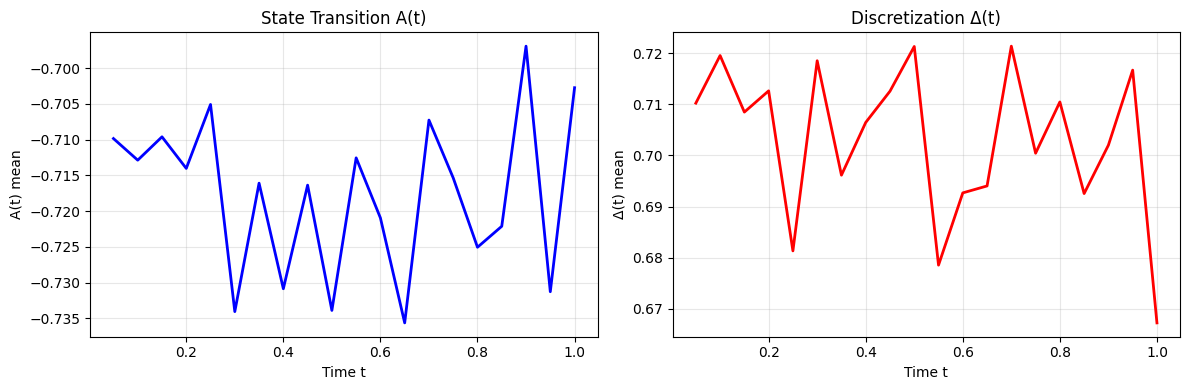

✓ SSM parameters vary with time!


In [34]:
# Sample parameters at different times
time_points = jnp.linspace(0.05, 1.0, 20)
A_trace, delta_trace = [], []

for t in time_points:
    te = time_emb_module(NamedArray(jnp.array(t), ()))
    A, B, C, D, delta = ssm_block.ssm._get_params(te)
    A_trace.append(jnp.mean(A.array))
    delta_trace.append(jnp.mean(delta.array))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(time_points, A_trace, 'b-', linewidth=2)
ax1.set_xlabel('Time t'); ax1.set_ylabel('A(t) mean')
ax1.set_title('State Transition A(t)'); ax1.grid(True, alpha=0.3)

ax2.plot(time_points, delta_trace, 'r-', linewidth=2)
ax2.set_xlabel('Time t'); ax2.set_ylabel('Δ(t) mean')
ax2.set_title('Discretization Δ(t)'); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ SSM parameters vary with time!")


## Summary & Next Steps

### Implemented:
- Time-varying SSM with hypernetwork-generated parameters
- Drop-in replacement for MLP in Neural ODE transformer  
- Verified time-dependent behavior

### Key Results:
- SSM successfully replaces FFN while maintaining ODE structure
- Parameters (A, B, C, Δ) smoothly vary across time interval [0,1]
- Ready for integration into full training pipeline

### Next Actions:

1. **Full Training**: Train on WikiText-103 or OpenWebText
2. **Ablations**: 
   - SSM state sizes: 32, 64, 128, 256
   - Hybrid: α(t)·FFN + (1-α(t))·SSM
   - Parallel: Both FFN and SSM paths
3. **Long Context Eval**: Test on >2K token sequences
4. **Optimize**: Add custom CUDA kernels for selective scan

### 💡 Integration:
```python
# In qkvflow/train_lm.py, add:
if config.model_choice == "neuralode-ssm":
    model = NeuralOdeSSMLMHeadModel.init(...)
```

### 📚 References:
- Original paper: Neural ODE Transformers (ICLR 2025)
- Mamba: Linear-time sequence modeling  
- AI21 Jamba: Hybrid attention-SSM architecture
